RAG MVP for Operator Training (text + images)

In [ ]:
import os, io
from PIL import Image
import fitz  # PyMuPDF
import numpy as np
import faiss
from IPython.display import display

from sentence_transformers import SentenceTransformer
from langchain_openai import ChatOpenAI
from langchain.schema import Document
import hashlib


In [2]:
# --- 1) Settings ---
PDF_PATH = "data/ManualOp-Modo Manual SIF400_merged_SIF402.pdf"          # Place PDF here
MACHINE_NAME = "SIF402"               # Set the machine name
TOP_K = 3                             # Number of retrieved results

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in env")

# --- 2) Models ---
text_model = SentenceTransformer("all-MiniLM-L6-v2")
clip_model = SentenceTransformer("clip-ViT-B-32")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/.no_exist/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/adapter_config.json'
Ignored error while writing commit hash to /home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main: [Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/hub/models--sentence-transformers--clip-ViT-B-32/refs/main'.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# --- 3) Load PDF ---

def load_pdf(PDF_PATH, MACHINE_NAME, text_model, clip_model, min_size=30, ignore_top_pct=0.9, ignore_bottom_pct=0.1):
    """
    Extracts text and images from a PDF with filters.
    
    Args:
        PDF_PATH (str): Path to PDF.
        MACHINE_NAME (str): Machine name prefix (e.g., 'SIF401').
        text_model: SentenceTransformer model for text.
        clip_model: SentenceTransformer model for images.
        min_size (int): Minimum width/height for valid images.

    Returns:
        text_docs, text_embeddings, image_docs, image_embeddings
    """
    doc = fitz.open(PDF_PATH)
    text_docs, text_embeddings = [], []
    image_docs, image_embeddings = [], []
    seen_hashes = set()

    for page_num in range(len(doc)):
        page = doc[page_num]

        # --- Text ---
        text = page.get_text()
        if text.strip():
            emb = text_model.encode(text).astype("float32")
            text_embeddings.append(emb)
            text_docs.append(
                Document(
                    page_content=text,
                    metadata={"page": page_num+1, "machine": MACHINE_NAME}
                )
            )

        # --- Images ---
        img_list = page.get_images(full=True)
        for img_index, img in enumerate(img_list, start=1):
            
            # Example region filter: skip if image is in top 10% or bottom 10% of page        
            x0, y0, x1, y1 = img[0:4]
            page_height = page.rect.height
            if y0 < page_height * ignore_bottom_pct or y1 > page_height * ignore_top_pct:
                continue  # skip logos/icons in header/footer            
            
            xref = img[0]                      
           
            base_img = doc.extract_image(xref)
            img_bytes = base_img["image"]
            img_ext = base_img["ext"]
            img_obj = Image.open(io.BytesIO(img_bytes)).convert("RGB")

            # Filters
            if img_obj.width < min_size or img_obj.height < min_size:
                continue  # skip small logos/icons

            #Skip completely black images
            # img_obj is your PIL.Image object
            img_array = np.array(img_obj)
            # Check if all pixels are 0 (black)
            if img_array.ndim == 3:  # RGB
                if np.all(img_array == 0):
                    continue  # skip completely black image
            elif img_array.ndim == 2:  # grayscale
                if np.all(img_array == 0):
                    continue            
            
            # Check for duplicates using hash
            img_hash = hashlib.md5(img_bytes).hexdigest()
            if img_hash in seen_hashes:
                continue  # skip duplicates
            seen_hashes.add(img_hash)



            # Save image
            out_path = f"data/page{page_num+1}_img{img_index}.{img_ext}"
            img_obj.save(out_path)

            # Embed + save doc
            emb = clip_model.encode(img_obj).astype("float32")
            image_docs.append(
                Document(
                    page_content=f"{MACHINE_NAME}_unknown image on page {page_num+1}, index {img_index}",
                    metadata={
                        "page": page_num+1,
                        "img_path": out_path,
                        "machine": MACHINE_NAME,
                        "object_tag": f"{MACHINE_NAME}_unknown"
                    }
                )
            )
            image_embeddings.append(emb)

    return text_docs, text_embeddings, image_docs, image_embeddings

text_docs, text_embeddings, image_docs, image_embeddings = load_pdf(
    PDF_PATH, MACHINE_NAME, text_model, clip_model
)

In [4]:
# --- 4) Build FAISS indexes ---

text_embeddings = np.vstack(text_embeddings)
image_embeddings = np.vstack(image_embeddings)

text_index = faiss.IndexFlatL2(text_embeddings.shape[1])
text_index.add(text_embeddings)

image_index = faiss.IndexFlatL2(image_embeddings.shape[1])
image_index.add(image_embeddings)

print(f"Indexed {len(text_docs)} text chunks and {len(image_docs)} images.")



Indexed 39 text chunks and 27 images.


In [5]:
# --- 5) Retriever ---
def retrieve(query, k=TOP_K):
    q_text_emb = text_model.encode(query).astype("float32")
    q_img_emb = clip_model.encode(query).astype("float32")

    # Text retrieval
    D, I = text_index.search(np.array([q_text_emb]), k)
    text_results = [text_docs[i] for i in I[0]]

    # Image retrieval
    D, I = image_index.search(np.array([q_img_emb]), k)
    image_results = [image_docs[i] for i in I[0]]

    return text_results, image_results



In [6]:
def rank_images_for_query(query, candidate_images, candidate_embs, img_top_k=2, score_threshold=0.15):
    """Return top-k most relevant images to a query from given candidates.
       Only keep images above a similarity threshold."""
    if not candidate_images:
        return []

    # Encode query with CLIP
    query_emb = clip_model.encode([query]).astype("float32")

    # Build FAISS index for candidate images
    dim = len(query_emb[0])
    index = faiss.IndexFlatIP(dim)
    index.add(np.array(candidate_embs))

    # Search similarity
    D, I = index.search(query_emb, len(candidate_embs))

    # Debug: show scores
    print("\n[DEBUG] Image ranking scores:")
    kept_images = []
    for rank, idx in enumerate(I[0]):
        score = D[0][rank]
        img_meta = candidate_images[idx].metadata
        print(f"  {rank+1}. Page {img_meta['page']} | Tag: {img_meta['object_tag']} | Score: {score:.4f}")

        if score >= score_threshold:
            kept_images.append((candidate_images[idx], score))

    # Return top-k ranked images above threshold
    kept_images = sorted(kept_images, key=lambda x: x[1], reverse=True)
    return [img for img, _ in kept_images[:img_top_k]]

In [ ]:
# --- 6) RAG answer ---
def ask(query, k=TOP_K, img_top_k=2, score_threshold=0.15):
    """Instead of dumping all images from relevant pages, we:
    Grab only candidate images from retrieved text pages.
    Encode the query with CLIP.
    Compute similarity between query and each candidate image.
    Keep the top-img_top_k most relevant ones."""

     # --- 1) Retrieve text first ---
    text_results, _ = retrieve(query, k)

    if not text_results:
        print("No relevant text found.")
        return

    # --- 2) Collect pages and machine from text ---
    retrieved_pages = {t.metadata['page'] for t in text_results}
    machine_name = text_results[0].metadata.get('machine', None)

    # --- 3) Collect candidate images from these pages ---
    candidate_images = [
        im for im in image_docs
        if im.metadata['page'] in retrieved_pages and 
           (machine_name is None or im.metadata['machine'] == machine_name)
    ]
    candidate_embs = [
        image_embeddings[image_docs.index(im)] for im in candidate_images
    ]

    # --- 4) Rank candidate images ---
    filtered_images = rank_images_for_query(
        query, candidate_images, candidate_embs,
        img_top_k=img_top_k, score_threshold=score_threshold
    )

    # --- 5) Prepare context ---
    context_parts = []
    for t in text_results:
        context_parts.append(f"[Text | Page {t.metadata['page']} | {t.metadata['machine']}]\n{t.page_content}")
    for im in filtered_images:
        context_parts.append(f"[Image | Page {im.metadata['page']} | Tag: {im.metadata['object_tag']}] {im.metadata['img_path']}")

    context = "\n\n".join(context_parts)
    prompt = f"""
    You are a safety-minded operator assistant.
    Query: {query}

    Context:
    {context}

    Answer step-by-step and cite sources (pages and object tags).    
    If you don't know the answer, just say you don't know."""

    # --- 6) Generate LLM answer ---
    answer = llm.invoke(prompt).content

    # --- 7) Display ---
    print("\n=== Answer ===\n")
    print(answer)

    if filtered_images:
        print("\n=== Supporting Images ===\n")
        for im in filtered_images:
            print(f"- Page {im.metadata['page']} | Tag: {im.metadata['object_tag']}")
            display(Image.open(im.metadata["img_path"]))
    else:
        print("\n=== No supporting images passed the relevance threshold ===")




[DEBUG] Image ranking scores:
  1. Page 23 | Tag: SIF402_unknown | Score: 30.9906
  2. Page 23 | Tag: SIF402_unknown | Score: 30.5137
  3. Page 15 | Tag: SIF402_unknown | Score: 28.7138
  4. Page 15 | Tag: SIF402_unknown | Score: 28.6815
  5. Page 16 | Tag: SIF402_unknown | Score: 28.3468
  6. Page 16 | Tag: SIF402_unknown | Score: 27.7691

=== Answer ===

To switch on and start up the station SIF402, follow these step-by-step instructions:

### Step 1: Reset the Station
1. **Press the Emergency Stop Push Button**: This is a safety measure to ensure that the station is in a safe state before starting.
2. **Release the Emergency Stop Push Button**: After pressing it, release it to allow the system to check its status.
   - **Observation**: The HMI screen will display a message in red indicating “Emergency status,” and the Emergency Stop push button will start flashing. You should also see a message in green indicating “X2X Bus Module status OK” (Source: Page 15, Section 1.15).

### Ste

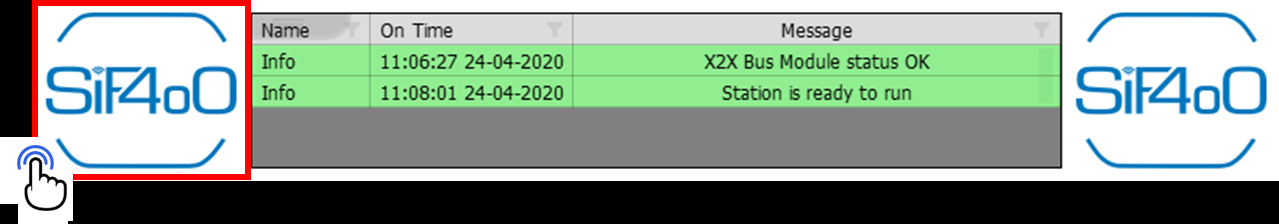

- Page 23 | Tag: SIF402_unknown


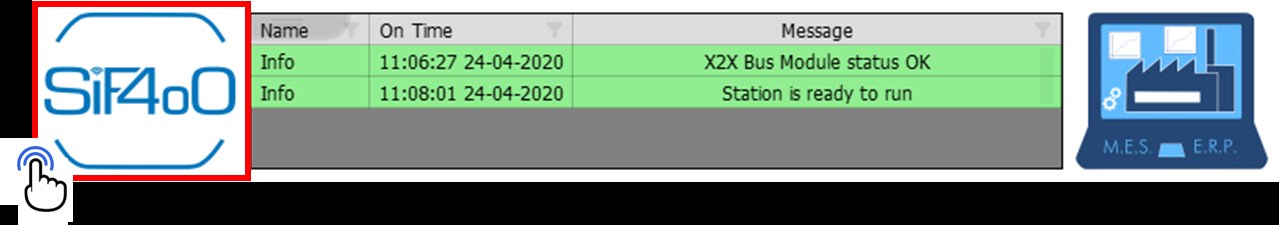

In [8]:
# --- 7) Example usage ---
if __name__ == "__main__":
    ask(f"How to switch on and start up the station {MACHINE_NAME} ?")